# Table of Contents
 <p><div class="lev1 toc-item"><a href="#reading-and-preparing-data" data-toc-modified-id="reading-and-preparing-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>reading and preparing data</a></div>

# reading and preparing data

In [8]:
#library(ggbiplot)
library(plyr)
library(tidyverse, quiet=T)
library(traj)
library(caret, quiet=T)

In [45]:
dat0 <- read.csv("../training_ultrasound.csv")

# Use Hadlok equation to estimate fetal weight from the 4 key ultrasound measurements
dat.raw = dat0 %>%
    mutate(
        LOG10.FWT.GM = 1.3596 + 0.0064*HCIRCM + 0.0424*ABCIRCM + 0.174*FEMURCM + 0.00061*BPDCM*ABCIRCM - 0.00386*ABCIRCM*FEMURCM,
        WTKG.estimate = ifelse(AGEDAYS<1 ,(10^LOG10.FWT.GM)/1000 ,WTKG) ,
        Study = paste('Study', STUDYID),
        PARITY = ifelse(STUDYID==1, PARITY-1, PARITY)
        )
dat.raw %>% glimpse
# clean data, remove samples with only one observation and after-birth
dat = dat.raw %>% group_by(SUBJID) %>%
    mutate(tot.measurements = n()) %>%
    filter(tot.measurements >1) %>%
    filter(AGEDAYS<0)


dat.train.raw = dat %>% ungroup %>%
    select(GAGEDAYS, SUBJID, ABCIRCM, HCIRCM, BPDCM, FEMURCM, PARITY, STUDYID, SEX, BWT_40) %>%
#    filter(!is.na(ABCIRCM)) %>% group_by(SUBJID) %>%
    filter(complete.cases(.)) %>%
    mutate(measurementId = row_number(), tot_measurements=n()) %>%
#    filter(measurementId < 7) %>%
#    filter(tot_measurements >1) %>% 
    ungroup
#     filter(GAGEDAYS > 150, GAGEDAYS <210)

dat.train = dat.train.raw

dat.train.raw %>% head

Observations: 17,370
Variables: 37
$ STUDYID       <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ SUBJID        <int> 1002, 1002, 1002, 1003, 1003, 1003, 1003, 1003, 1003,...
$ SEXN          <int> 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ SEX           <fctr> Female, Female, Female, Male, Male, Male, Male, Male...
$ GAGEBRTH      <int> 276, 276, 276, 280, 280, 280, 280, 280, 280, 280, 280...
$ BIRTHWT       <int> 3540, 3540, 3540, 3100, 3100, 3100, 3100, 3100, 3100,...
$ BIRTHLEN      <dbl> 50.3, 50.3, 50.3, 50.3, 50.3, 50.3, 50.3, 50.3, 50.3,...
$ BIRTHHC       <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N...
$ DELIVERY      <fctr> Category 2.0, Category 2.0, Category 2.0, Category 2...
$ PARITY        <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ GRAVIDA       <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ GAGEDAYS      <int> 255, 277, 669, 223, 224, 263, 266, 281, 321, 463, 645...
$ AGEDAYS       <

GAGEDAYS,SUBJID,ABCIRCM,HCIRCM,BPDCM,FEMURCM,PARITY,STUDYID,SEX,BWT_40,measurementId,tot_measurements
255,1002,32.5,33.4,9.1,7.3,0,1,Female,3.614882,1,7827
223,1003,25.6,29.2,8.2,6.3,0,1,Male,3.100000,2,7827
224,1003,25.6,29.2,8.2,6.3,0,1,Male,3.100000,3,7827
263,1003,30.2,31.0,9.1,7.2,0,1,Male,3.100000,4,7827
266,1003,30.2,31.0,9.1,7.2,0,1,Male,3.100000,5,7827
169,1005,18.7,21.9,5.9,4.1,0,1,Male,2.988224,6,7827


# simple regression using GAGEDAYS as covariate

In [57]:
ctrl <- trainControl( method="boot", number=10, repeats=3)

dat.gbm = train(BWT_40~., 
                data=dat.train.raw %>%select(-measurementId, -tot_measurements, -SUBJID), 
                method="gbm", 
                preProcess=c("center", "scale", "knnImpute"), 
                verbose=F)


In [65]:
dat.gbm$modelInfo

parameter,class,label
n.trees,numeric,# Boosting Iterations
interaction.depth,numeric,Max Tree Depth
shrinkage,numeric,Shrinkage
n.minobsinnode,numeric,Min. Terminal Node Size


,var,rel.inf
ABCIRCM,ABCIRCM,42.3102187
GAGEDAYS,GAGEDAYS,34.7568922
FEMURCM,FEMURCM,7.0196893
SEXMale,SEXMale,6.5910654
BPDCM,BPDCM,4.7765837
HCIRCM,HCIRCM,2.6879421
PARITY,PARITY,1.5100042
STUDYID,STUDYID,0.3476046


RMSE,Rsquared,Resample
0.3032589,0.2917749,Resample21
0.3015564,0.3059881,Resample22
0.3057093,0.2944590,Resample17
0.3016174,0.3149452,Resample18
0.3093300,0.2957633,Resample23
0.2950080,0.3005937,Resample12
0.3044913,0.3033495,Resample13
0.2985422,0.3008291,Resample14
0.3063371,0.3216967,Resample19
0.3016530,0.2819735,Resample08


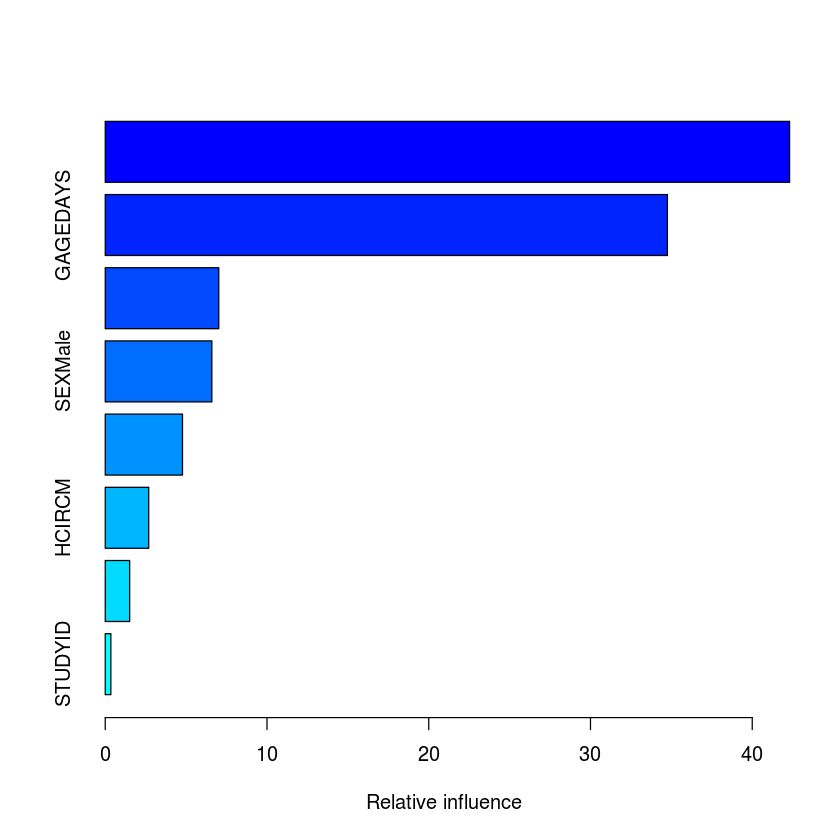

In [60]:
dat.gbm %>% summary


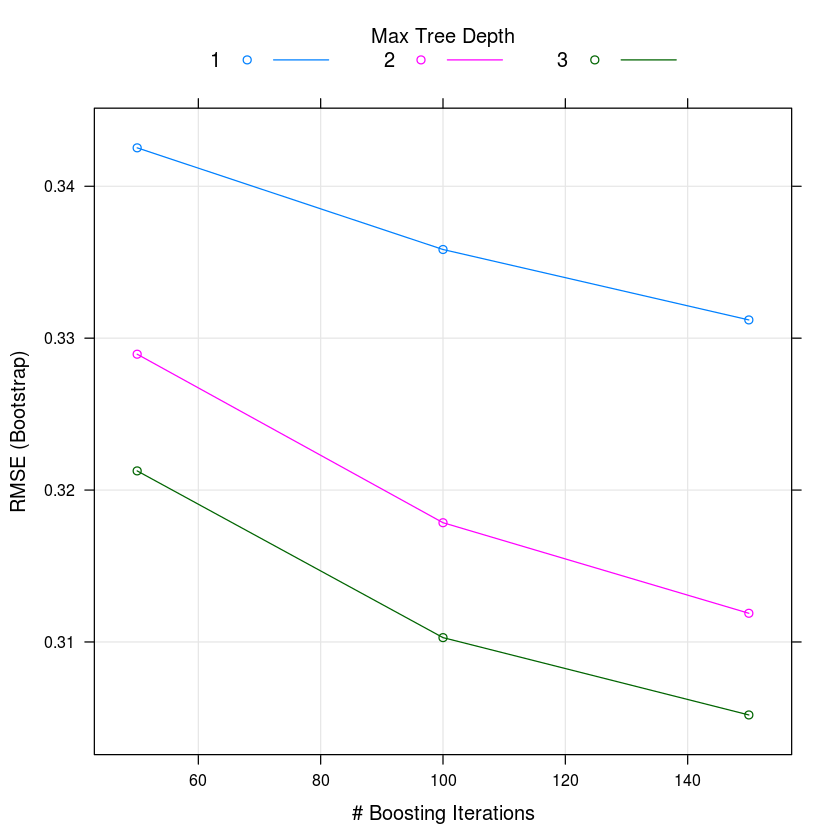

In [47]:
plot(dat.gbm)

gbm variable importance

         Overall
ABCIRCM  100.000
GAGEDAYS  73.519
SEXMale   13.279
FEMURCM   13.051
BPDCM     11.179
HCIRCM     7.329
PARITY     2.643
STUDYID    0.000

Stochastic Gradient Boosting 

7827 samples
   8 predictors

Pre-processing: centered (8), scaled (8), nearest neighbor imputation (8) 
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 7827, 7827, 7827, 7827, 7827, 7827, ... 
Resampling results across tuning parameters:

  interaction.depth  n.trees  RMSE       Rsquared 
  1                   50      0.3397188  0.1270177
  1                  100      0.3329582  0.1631067
  1                  150      0.3282487  0.1863651
  2                   50      0.3256746  0.2028317
  2                  100      0.3146452  0.2497748
  2                  150      0.3085135  0.2744417
  3                   50      0.3183449  0.2364240
  3                  100      0.3068683  0.2823535
  3                  150      0.3021581  0.2995447

Tuning parameter 'shrinkage' was held constant at a value of 0.1

Tuning parameter 'n.minobsinnode' was held constant at a value of 10
RMSE was used to select the optimal model using  the smallest value.
T

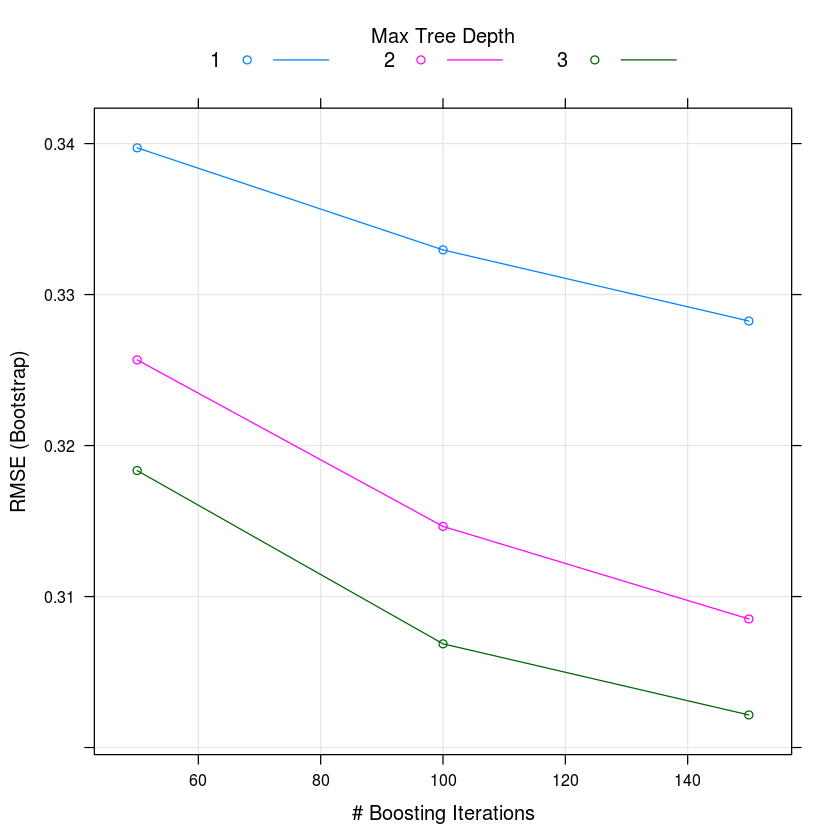

In [54]:
varImp(dat.gbm)
dat.gbm
plot(dat.gbm)

# Model for first weeks (15 to 25)


In [50]:
ctrl <- trainControl(method="repeatedcv", number=10, repeats=3)

dat.gbm = train(BWT_40~., 
                data=dat.train.raw %>% select(-measurementId, -tot_measurements, -SUBJID) %>%
                    filter(GAGEDAYS> 15*7, GAGEDAYS<25*7), 
                method="gbm", 
                preProcess=c("center", "scale", "knnImpute"), 
                verbose=F)

gbm variable importance

         Overall
GAGEDAYS  100.00
ABCIRCM    93.12
HCIRCM     68.62
FEMURCM    46.02
BPDCM      29.54
SEXMale    21.96
PARITY     11.61
STUDYID     0.00

Stochastic Gradient Boosting 

1625 samples
   8 predictors

Pre-processing: centered (8), scaled (8), nearest neighbor imputation (8) 
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1625, 1625, 1625, 1625, 1625, 1625, ... 
Resampling results across tuning parameters:

  interaction.depth  n.trees  RMSE       Rsquared  
  1                   50      0.3567503  0.08471134
  1                  100      0.3534903  0.09898450
  1                  150      0.3517074  0.10760393
  2                   50      0.3519120  0.10696286
  2                  100      0.3495576  0.11925697
  2                  150      0.3498290  0.12178875
  3                   50      0.3498301  0.11670139
  3                  100      0.3494758  0.12322557
  3                  150      0.3508800  0.12313697

Tuning parameter 'shrinkage' was held constant at a value of 0.1

Tuning parameter 'n.minobsinnode' was held constant at a value of 10
RMSE was used to select the optimal model using  the smalles

ERROR: Error in confusionMatrix.train(dat.gbm): confusion matrices are only valid for classification models


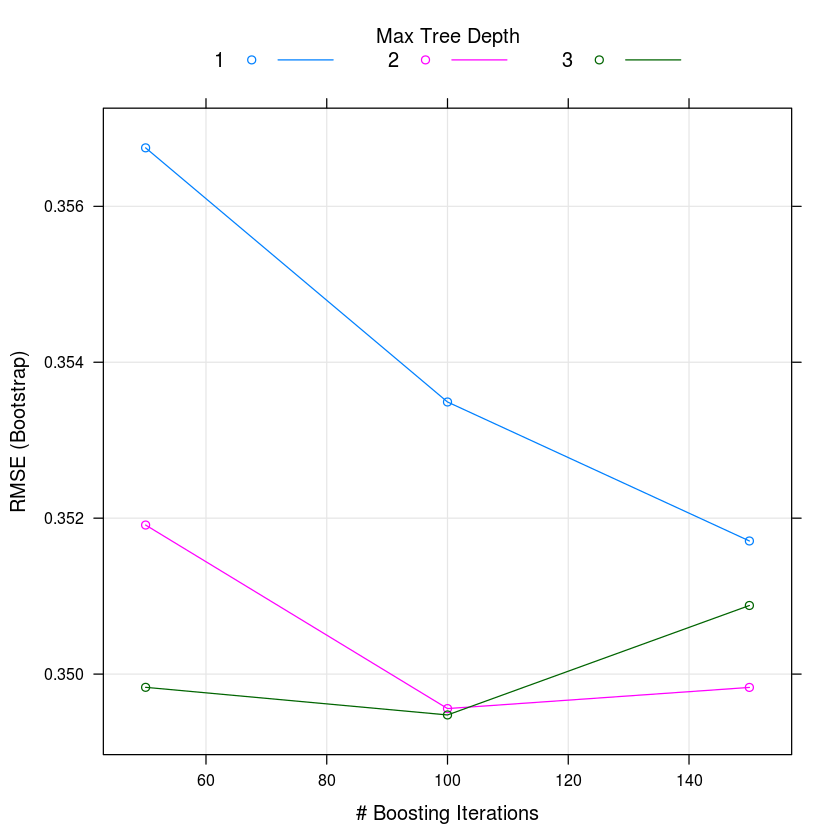

In [52]:
varImp(dat.gbm)
dat.gbm
plot(dat.gbm)